In [13]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
class GridWorld:
    def __init__(self, size=9, gamma=0.9):
        self.size = size
        self.gamma = gamma
        self.start = (0, 0)
        self.goal = (size-1, size-1)
        self.tunnel_in = (2, 2)
        self.tunnel_out = (6, 6)
        self.walls = [(3, 1), (3, 2), (3, 3), (1, 3), (2, 3),
                      (5, 5), (5, 6), (5, 7), (5, 8), (6, 5),
                      (7, 5), (8, 5)]
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # right, down, left, up

    def is_valid(self, state):
        return 0 <= state[0] < self.size and 0 <= state[1] < self.size and state not in self.walls

    def get_next_state(self, state, action):
        if state == self.tunnel_in:
            return self.tunnel_out
        next_state = (state[0] + action[0], state[1] + action[1])
        return next_state if self.is_valid(next_state) else state

    def get_reward(self, state):
        return 1 if state == self.goal else 0


In [15]:

class MDPSolver:
    def __init__(self, grid_world):
        self.grid = grid_world
        self.V = np.zeros((grid_world.size, grid_world.size))
        self.policy = [[[] for _ in range(grid_world.size)] for _ in range(grid_world.size)]

    def value_iteration(self, epsilon=1e-6):
        while True:
            delta = 0
            for i in range(self.grid.size):
                for j in range(self.grid.size):
                    if (i, j) in self.grid.walls or (i, j) == self.grid.goal:
                        continue
                    v = self.V[i, j]
                    self.V[i, j] = max(self.grid.get_reward(self.grid.get_next_state((i, j), a)) + 
                                       self.grid.gamma * self.V[self.grid.get_next_state((i, j), a)] 
                                       for a in self.grid.actions)
                    delta = max(delta, abs(v - self.V[i, j]))
            if delta < epsilon:
                break
        self._update_policy()

    def policy_iteration(self):
        while True:
            self._policy_evaluation()
            if not self._policy_improvement():
                break

    def _policy_evaluation(self):
        while True:
            delta = 0
            for i in range(self.grid.size):
                for j in range(self.grid.size):
                    if (i, j) in self.grid.walls or (i, j) == self.grid.goal:
                        continue
                    v = self.V[i, j]
                    # Use the first action in the policy list for evaluation
                    action = self.grid.actions[self.policy[i][j][0]] if self.policy[i][j] else self.grid.actions[0]
                    next_state = self.grid.get_next_state((i, j), action)
                    self.V[i, j] = self.grid.get_reward(next_state) + self.grid.gamma * self.V[next_state]
                    delta = max(delta, abs(v - self.V[i, j]))
            if delta < 1e-6:
                break

    def _policy_improvement(self):
        policy_stable = True
        for i in range(self.grid.size):
            for j in range(self.grid.size):
                if (i, j) in self.grid.walls or (i, j) == self.grid.goal:
                    continue
                old_actions = self.policy[i][j]
                action_values = [self.grid.get_reward(self.grid.get_next_state((i, j), a)) + 
                                 self.grid.gamma * self.V[self.grid.get_next_state((i, j), a)] 
                                 for a in self.grid.actions]
                max_value = max(action_values)
                best_actions = [idx for idx, value in enumerate(action_values) if value == max_value]
                self.policy[i][j] = best_actions
                if set(old_actions) != set(best_actions):
                    policy_stable = False
        return policy_stable

    def _update_policy(self):
        for i in range(self.grid.size):
            for j in range(self.grid.size):
                if (i, j) in self.grid.walls or (i, j) == self.grid.goal:
                    continue
                action_values = [self.grid.get_reward(self.grid.get_next_state((i, j), a)) + 
                                 self.grid.gamma * self.V[self.grid.get_next_state((i, j), a)] 
                                 for a in self.grid.actions]
                max_value = max(action_values)
                self.policy[i][j] = [idx for idx, value in enumerate(action_values) if value == max_value]


In [17]:

def visualize_policy(grid, V, policy, title):
    action_symbols = ['→', '↓', '←', '↑']
    data = []
    for i in range(grid.size):
        for j in range(grid.size):
            if (i, j) in grid.walls:
                cell_type = 'Wall'
                value = np.nan
                action = ''
            elif (i, j) == grid.goal:
                cell_type = 'Goal'
                value = np.nan
                action = '★'
            elif (i, j) == grid.start:
                cell_type = 'Start'
                value = V[i, j]
                action = ''.join(action_symbols[a] for a in policy[i][j])
            elif (i, j) == grid.tunnel_in:
                cell_type = 'Tunnel In'
                value = V[i, j]
                action = 'IN'
            elif (i, j) == grid.tunnel_out:
                cell_type = 'Tunnel Out'
                value = V[i, j]
                action = 'OUT'
            else:
                cell_type = 'Normal'
                value = V[i, j]
                action = ''.join(action_symbols[a] for a in policy[i][j])
            data.append([i, j, cell_type, value, action])
            
    df = pd.DataFrame(data, columns=['Row', 'Col', 'Type', 'Value', 'Action'])
    
    value_pivot = df.pivot(index='Row', columns='Col', values='Value')
    action_pivot = df.pivot(index='Row', columns='Col', values='Action')

    plt.figure(figsize=(12, 10))
    sns.set(font_scale=1.2)
    
    heatmap = sns.heatmap(value_pivot, annot=action_pivot, 
                          fmt='', cmap='YlOrRd', cbar_kws={'label': 'Value'})
    
    heatmap.invert_yaxis()
    plt.title(title)
    plt.show()


In [18]:
# Main execution
grid_world = GridWorld()
solver = MDPSolver(grid_world)

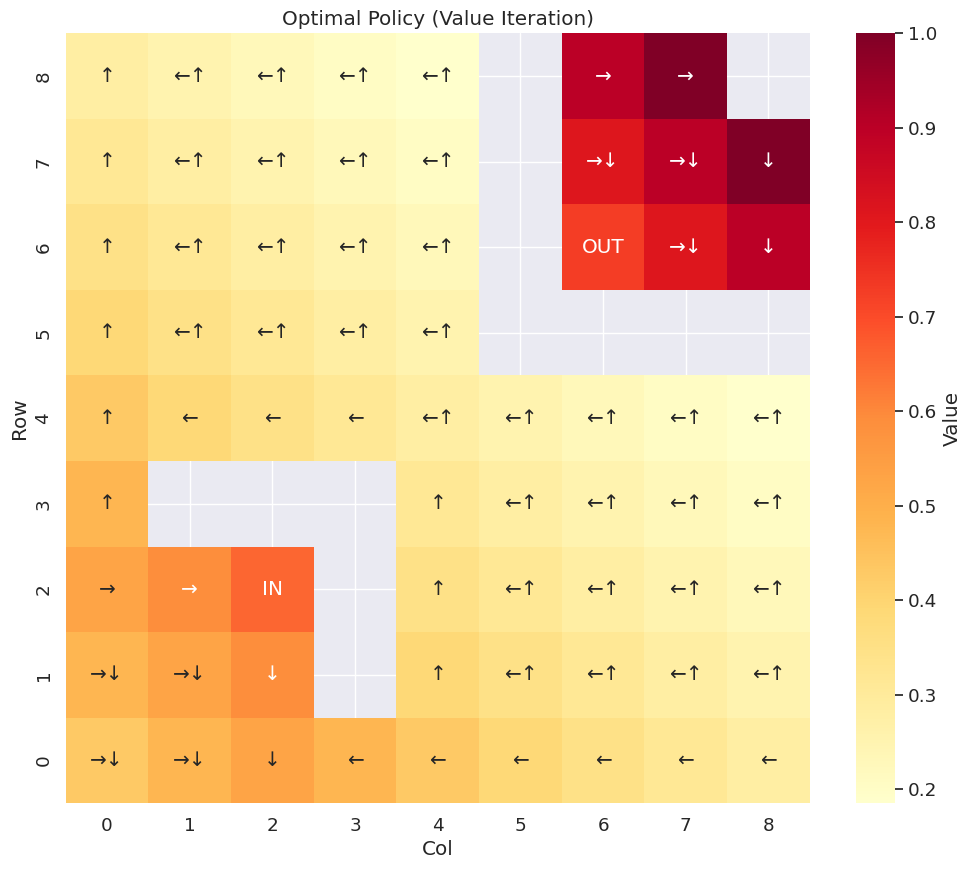

In [19]:
# Value Iteration
solver.value_iteration()
visualize_policy(grid_world, solver.V, solver.policy, "Optimal Policy (Value Iteration)")


In [20]:
# Reset solver for Policy Iteration
solver = MDPSolver(grid_world)

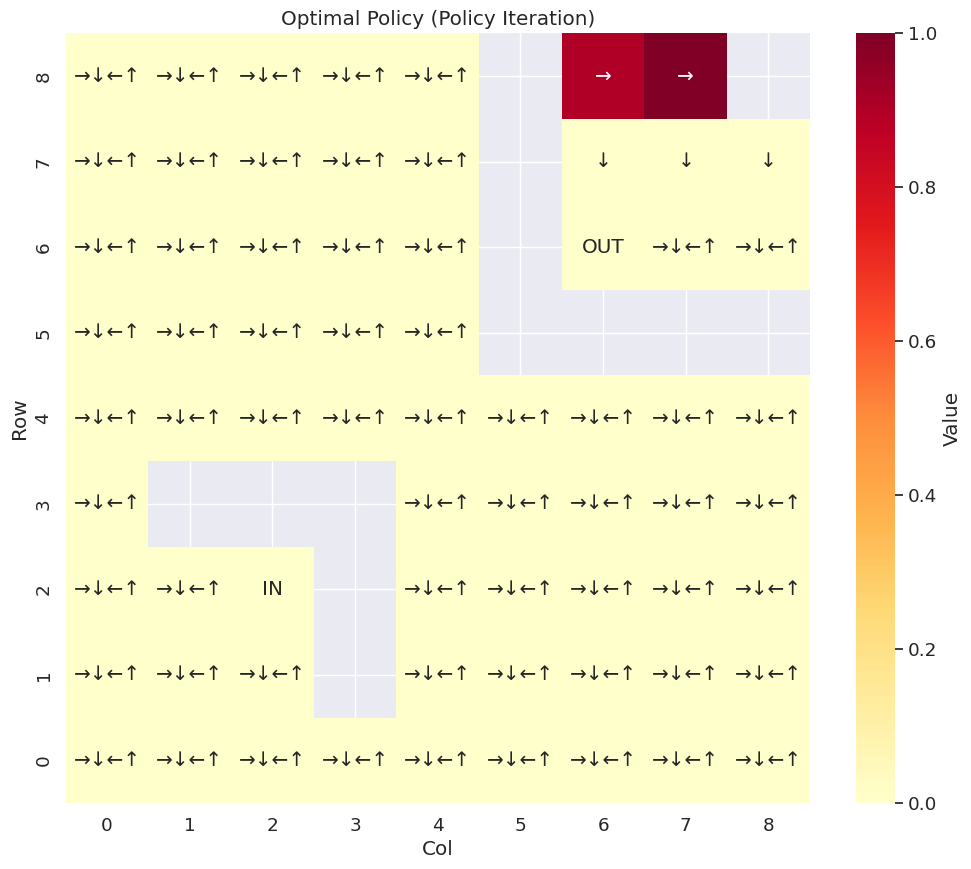

In [21]:

# Policy Iteration
solver.policy_iteration()
visualize_policy(grid_world, solver.V, solver.policy, "Optimal Policy (Policy Iteration)")